<a href="https://colab.research.google.com/github/bgoueti/BandersnatchStarter/blob/main/Machine_Learning_BandersnatchStarter_Project_Sprint_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Machine Learning BandersnatchStarter Project - Sprint 3**

**Objective**

Machine Learning Model

- Notebook exploration
- Machine Learning interface class
- Model serialization (save and open)
- API model integration


**Guidance**

**A. Notebook Model Training & Tuning**
 - Create a notebook for model testing and tuning
 - Train and tune at least 3 models using the data generated in an earlier Sprint
 - Measure the accuracy of the models and report info about your best model
 - Write a paragraph or two about your best model


In [1]:
%%capture
import sys

if 'google.colab' in sys.modules:
  !pip install numpy altair pandas scikit-learn matplotlib openai
  !pip install category_encoders
  !pip install matplotlib==3.7.1
  !pip install pdpbox

In [49]:
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.impute import SimpleImputer
from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression,LinearRegression
from sklearn.inspection import PartialDependenceDisplay
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, cross_val_score


In [3]:
from datetime import datetime
from glob import glob
from IPython.display import Image
from typing import Tuple, Dict, Any
from pprint import pprint
from altair import Chart
from pandas import DataFrame
from sklearn import metrics

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import altair as alt
import joblib
import requests
import json
import os

# **Upload data (Colab) and Load the JSON/CSV file into a DataFrame**

In [5]:
# Upload file in Colab
try:
  from google.colab import files
  IN_COLAB = True
except Exception:
  IN_COLAB = False

if IN_COLAB:
  print("Please upload json file now or csv file")
  uploaded = files.upload()
  fn = list(uploaded.keys())[0]
else:
  fn = "mosters.json"

print("Using:", fn)

Please upload json file now or csv file


Saving monsters.csv to monsters.csv
Using: monsters.csv


In [6]:
file_path = "monsters.csv"
df = pd.read_csv(file_path)
df.head()

,Name,Type,Level,Rarity,Damage,Health,Energy,Sanity,Timestamp
0,Skeletal Villager,Undead,11.0,Rank 1,11d4+1,44.63,43.26,43.77,10/29/2025 15:13
1,Ghostly Villager,Undead,3.0,Rank 1,3d4+2,11.11,12.42,13.53,10/29/2025 15:13
2,Lightning Elemental,Elemental,2.0,Rank 3,2d8,19.89,18.19,19.80,10/29/2025 15:13
3,Djinni,Elemental,2.0,Rank 2,2d6,10.27,14.09,13.63,10/29/2025 15:13
4,Demilich,Undead,11.0,Rank 0,11d2+3,22.14,22.96,22.91,10/29/2025 15:13


# **Basic cleaning & expected columns**

Quick cleaning & ensure expected data columns

Ensure numeric types for features and non-null `Rarity`.

In [7]:
# Cell: Basic cleaning
expected = ["Level", "Health", "Energy", "Sanity", "Rarity"]
for col in expected:
  if col not in df.columns:
    df[col] = np.nan

# Convert numeric
for col in ["Level", "Health", "Energy", "Sanity"]:
  df[col] = pd.to_numeric(df[col], errors="coerce")

# Drop rows without Rarity
df = df.dropna(subset=["Rarity"]).reset_index(drop=True)

# Let drop rows where all numeric features are NaN
df = df.dropna(subset=["Level", "Health", "Energy", "Sanity"],
               how="all").reset_index(drop=True)

print("After cleaning rows:", len(df))
display(df[expected].head())


After cleaning rows: 1000


,Level,Health,Energy,Sanity,Rarity
0,11.0,44.63,43.26,43.77,Rank 1
1,3.0,11.11,12.42,13.53,Rank 1
2,2.0,19.89,18.19,19.80,Rank 3
3,2.0,10.27,14.09,13.63,Rank 2
4,11.0,22.14,22.96,22.91,Rank 0


# **Quick EDA (statistics / class counts)**

In [8]:
print("Rarity distribution:")
display(df['Rarity'].value_counts())
display(df[['Level', 'Health', 'Energy', 'Sanity']].describe().T)

Rarity distribution:


,count
Rarity,
Rank 0,316
Rank 1,257
Rank 2,175
Rank 3,133
Rank 4,89
Rank 5,30


,count,mean,std,min,25%,50%,75%,max
Level,1000.0,7.89400,4.418630,1.00,4.0000,7.000,11.0000,20.00
Health,1000.0,39.03665,33.347495,1.05,16.2950,27.770,51.3200,220.71
Energy,1000.0,39.28469,33.634929,1.73,16.3325,28.075,51.7775,220.17
Sanity,1000.0,39.12219,33.323662,1.00,15.6700,27.895,51.4100,220.69




# **Preparing features & target for modeling**

- Features: Level, Health, Energy, Sanity  
- Target: Rarity (label-encoded)

In [56]:
features = ['Level', 'Health', 'Energy', 'Sanity']
target = 'Rarity'

X = df[features].copy()
y = df[target].astype(str).copy()

# X = df.drop(columns=[target])
# y = df[target].astype(str)

In [57]:
# Fill numeric NaNs with median (which can be changed)
#X = X.fillna(X.median())

X = X.apply(pd.to_numeric, errors="coerce").fillna(0)

#Encode target labels
label_encode = LabelEncoder()
y_encoded = label_encode.fit_transform(y)

print("Classes:", list(label_encode.classes_))

Classes: ['Rank 0', 'Rank 1', 'Rank 2', 'Rank 3', 'Rank 4', 'Rank 5']


# **Train/Test split**
Use stratify to preserve class distribution if possible.

In [58]:
X_train, X_test, y_train, y_test= train_test_split(X, y_encoded,
                                                   test_size=0.2,
                                                   random_state=42,
                                                   stratify=y_encoded if len(set(y_encoded)) > 1 else None
                                                   )

In [59]:
X_train.shape, X_test.shape

((800, 4), (200, 4))

# **Baseline models — train 3 models and evaluation**

We'll train:
- RandomForestClassifier
- GradientBoostingClassifier
- LogisticRegression (with L2)

In [60]:
#Baseline Model
# y_train = pd.Series(y_train)
# baseline = y_train.value_counts(normalize=True).max()

baseline = np.bincount(y_train).max() / len(y_train)
print(f"Baseline accuracy (majority class): {baseline:.4f}")

Baseline accuracy (majority class): 0.3162


In [61]:
# Train Models With no Hyperparameters search
models = {
    "RandomForest": RandomForestClassifier(n_estimators=150),
    "GradientBoosting": GradientBoostingClassifier(random_state=42),
    "LogisticRegression": LogisticRegression(max_iter=500, random_state=42)
}

scores = {}

for name, model in models.items():
  model.fit(X_train, y_train)
  preds = model.predict(X_test)
  val = accuracy_score(y_test, preds)

  scores[name] = {"model":  model,
                  "accuracy": val,
                  "prediction": preds
                  }

  print(f"{name} accuracy: {val: .4f} \n")

scores

RandomForest accuracy:  0.9650 

GradientBoosting accuracy:  0.9200 

LogisticRegression accuracy:  0.9900 



/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


{'RandomForest': {'model': RandomForestClassifier(n_estimators=150),
  'accuracy': 0.965,
  'prediction': array([3, 0, 3, 0, 4, 0, 1, 2, 3, 0, 3, 2, 0, 3, 4, 5, 0, 1, 3, 1, 0, 4,
         0, 1, 4, 0, 4, 1, 2, 1, 4, 1, 1, 3, 4, 0, 2, 1, 3, 3, 0, 2, 0, 1,
         4, 1, 0, 2, 3, 2, 0, 1, 3, 2, 1, 2, 2, 4, 1, 2, 0, 2, 1, 2, 3, 1,
         3, 1, 2, 1, 0, 1, 0, 2, 2, 1, 0, 1, 2, 1, 1, 4, 1, 0, 0, 0, 0, 0,
         3, 0, 3, 3, 2, 1, 0, 3, 2, 0, 1, 0, 1, 1, 4, 1, 1, 2, 1, 5, 4, 1,
         0, 1, 3, 0, 1, 4, 3, 0, 4, 3, 1, 2, 0, 0, 1, 4, 0, 0, 0, 0, 4, 2,
         2, 0, 0, 1, 1, 0, 2, 3, 3, 0, 0, 2, 1, 0, 3, 2, 0, 1, 0, 1, 2, 1,
         1, 0, 3, 2, 0, 1, 0, 1, 0, 3, 2, 1, 0, 0, 0, 0, 2, 2, 1, 0, 2, 2,
         0, 0, 2, 4, 1, 0, 0, 1, 0, 4, 0, 5, 3, 0, 0, 2, 2, 4, 0, 2, 1, 5,
         1, 0])},
 'GradientBoosting': {'model': GradientBoostingClassifier(random_state=42),
  'accuracy': 0.92,
  'prediction': array([3, 0, 3, 0, 3, 0, 1, 2, 3, 0, 3, 2, 0, 3, 3, 5, 0, 1, 4, 1, 1, 4,
         0, 1, 4, 

# **Accuracy Comparison Table**

In [62]:
score_df = pd.DataFrame({
    "Model": scores.keys(),
    "Accuracy": [scores[m]["accuracy"] for m in scores]
})

score_df


,Model,Accuracy
0,RandomForest,0.965
1,GradientBoosting,0.920
2,LogisticRegression,0.990


# **Hyperparameter tuning (quick GridSearch)**
We'll do a small grid for each model to improve performance. Keep small to save time.

In [63]:
param_grids = {
    "RandomForest": {"n_estimators": [100, 150],
                     "max_depth": [None, 10, 20],
                     "min_samples_split": [2, 4, 6]
                     },
    "GradientBoosting": {"n_estimators": [100, 150],
                         "learning_rate": [0.05, 0.1]
                         },
    "LogisticRegression": {"C": [0.1, 1.0, 10.0]}
    }

best_models = {}
for name in param_grids:
  print("Tuning", name)
  base = models[name]
  grid = GridSearchCV(base,
                      param_grids[name],
                      cv=3,
                      n_jobs=-1,
                      scoring="accuracy",
                      verbose=0)

  grid.fit(X_train, y_train)
  best_models[name] = grid.best_estimator_

  print(" Best params:", grid.best_params_)
  print(" Best CV score:", grid.best_score_)

  # Test Evaluation
  preds = grid.best_estimator_.predict(X_test)
  test_acc = accuracy_score(y_test, preds)
  print(" Test accuracy:", test_acc)
  print()

Tuning RandomForest
 Best params: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 100}
 Best CV score: 0.9299794429894962
 Test accuracy: 0.96

Tuning GradientBoosting
 Best params: {'learning_rate': 0.1, 'n_estimators': 150}
 Best CV score: 0.8687683628547024
 Test accuracy: 0.935

Tuning LogisticRegression
 Best params: {'C': 10.0}
 Best CV score: 0.976256183529986
 Test accuracy: 0.99



/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# **Cross-Validation (K-Fold)**

In [71]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

rf = grid.best_estimator_

cv_scores = cross_val_score(rf, X,
                            y_encoded,
                            cv=kfold,
                            scoring="accuracy"
                            )
print("Cross-Validation Scores:", cv_scores)
print("Mean Accuracy:", cv_scores.mean())


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Cross-Validation Scores: [0.985 0.985 0.975 0.985 0.965]
Mean Accuracy: 0.9789999999999999


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# **Feature Importance Plot (RandomForest & GradientBoosting)**

In [67]:
def plot_feature_importance(model, X):
  plt.figure(figsize=(10, 6))

  # --- Tree-Based Models ---
  if hasattr(model, "feature_importances_"):
    importances = model.feature_importances_
  # --- Linear Models (Logistic Regression) ---
  elif hasattr(model, "coef_"):
    importances = np.abs(model.coef_[0])  # absolute importance
  else:
    raise ValueError("This model does not support feature importance.")

  # Sort indices
  indices = np.argsort(importances)[::-1]
  names = X.columns[indices]

  # Plot
  sns.barplot(x=importances[indices], y=names)
  plt.title(type(model).__name__ + " Feature Importance")
  plt.xlabel("Importance")
  plt.ylabel("Feature")
  plt.tight_layout()
  plt.show()


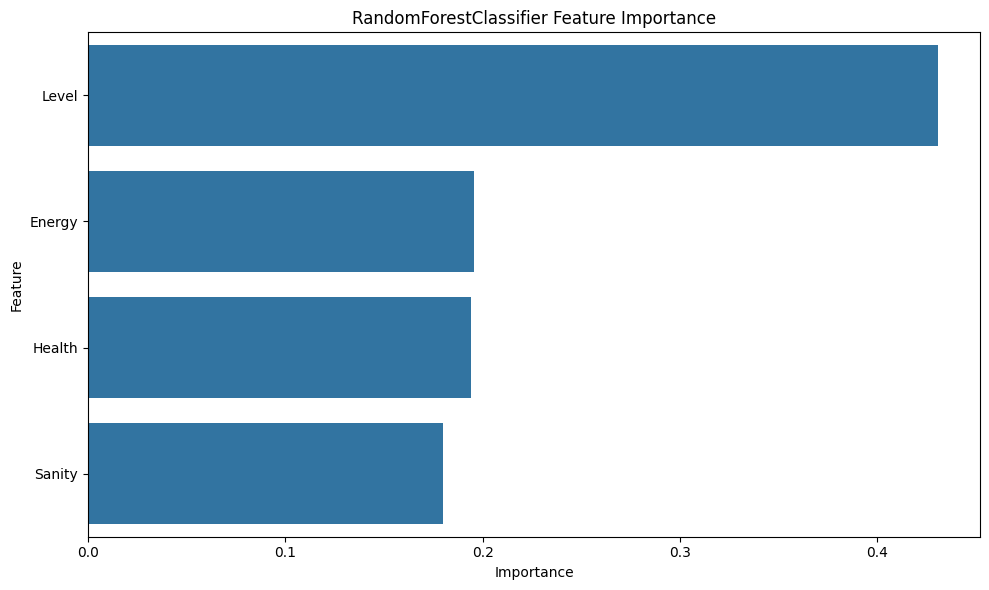

In [74]:
plot_feature_importance(models["RandomForest"], X_train)


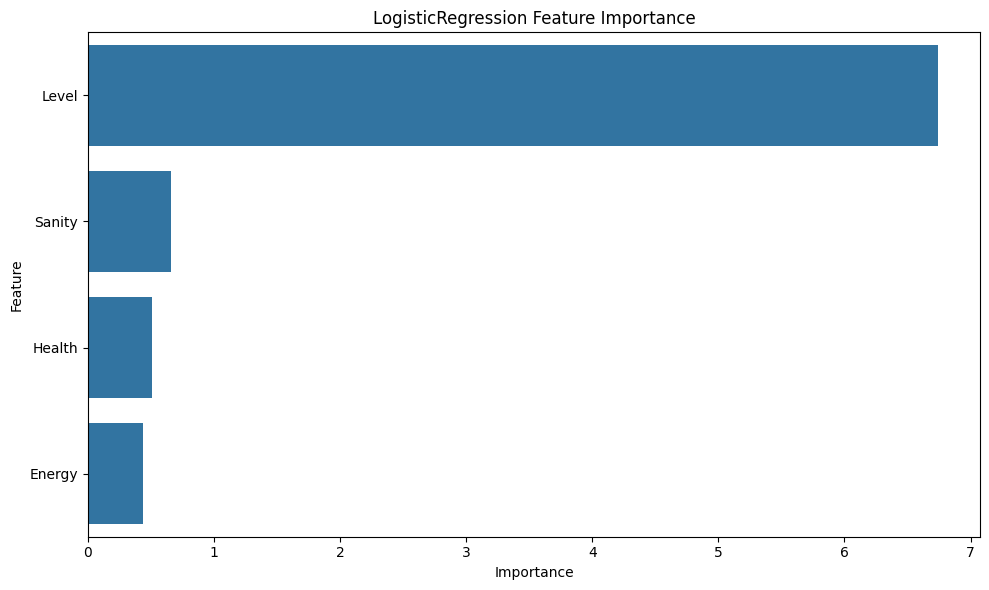

In [75]:
plot_feature_importance(models["LogisticRegression"], X_train)


**Logistic Regression feature importance is directional**

Coefficients > 0 → increase probability of class 1

Coefficients < 0 → increase probability of class 0

We use absolute values to visualize importance.

In [76]:
lr = models["LogisticRegression"]
coef_df = pd.DataFrame({
    "feature": X_train.columns,
    "coef": lr.coef_[0]
}).sort_values(by="coef", ascending=False)

coef_df


,feature,coef
0,Level,6.737969
2,Energy,-0.435378
1,Health,-0.511687
3,Sanity,-0.658629


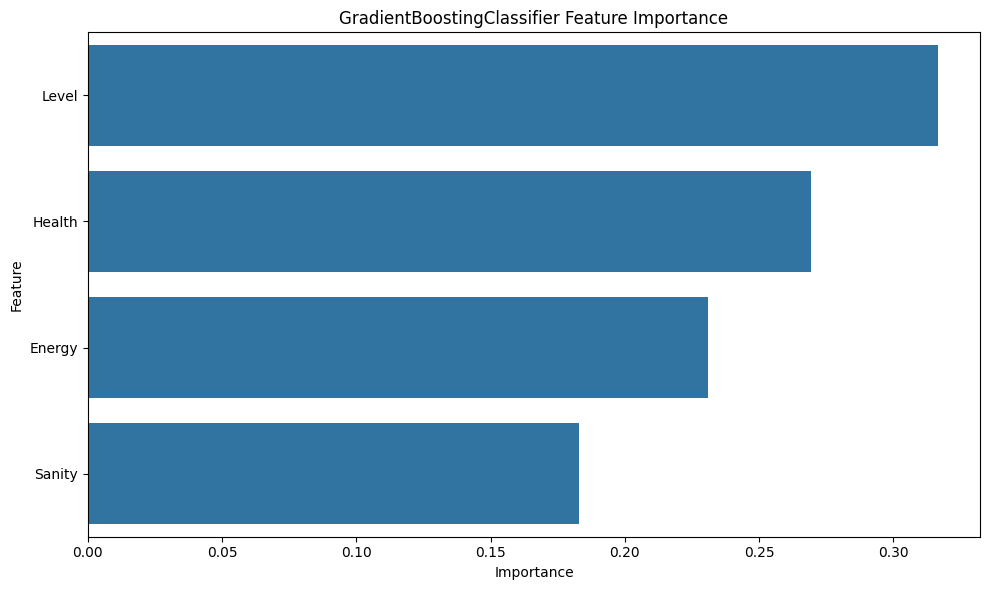

In [80]:
plot_feature_importance(models["GradientBoosting"], X_train)

In [79]:
# # RandomForest Feature Importance
# importances = rf.feature_importances_
# indices = np.argsort(importances)[::-1]

# plt.figure(figsize=(10,6))
# plt.bar(range(len(importances)), importances[indices])
# plt.xticks(range(len(importances)), X.columns[indices], rotation=90)
# plt.title("Random Forest Feature Importance")
# plt.show()


In [81]:
# # GradientBoosting Feature Importance
# gb = models["GradientBoosting"]
# importances = gb.feature_importances_
# indices = np.argsort(importances)[::-1]

# plt.figure(figsize=(10,6))
# plt.bar(range(len(importances)), importances[indices])
# plt.xticks(range(len(importances)), X.columns[indices], rotation=90)
# plt.title("Gradient Boosting Feature Importance")
# plt.show()


# **Save Best Model (.pkl)**

In [82]:
best_model = grid.best_estimator_

joblib.dump(best_model, "best_monster_model.pkl")
joblib.dump(label_encode, "label_encoder.pkl")

print("Model + encoder saved!")


Model + encoder saved!


# **Accuracy Bar Plot**

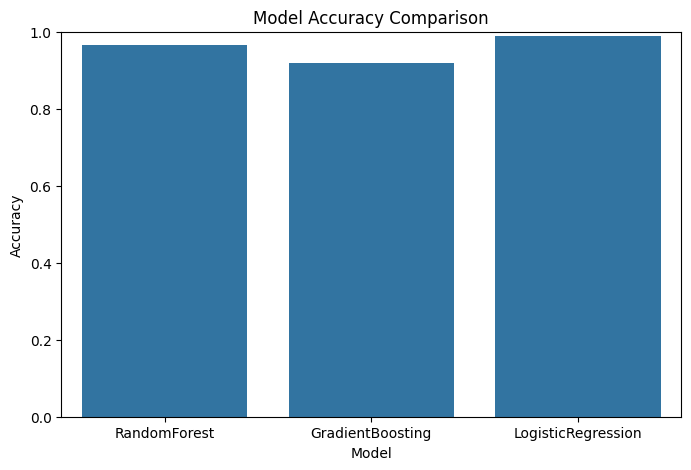

In [31]:
plt.figure(figsize=(8, 5))
sns.barplot(data=score_df, x="Model", y="Accuracy")
plt.title("Model Accuracy Comparison")
plt.ylim(0, 1)
plt.show()


# **Confusion Matrices**

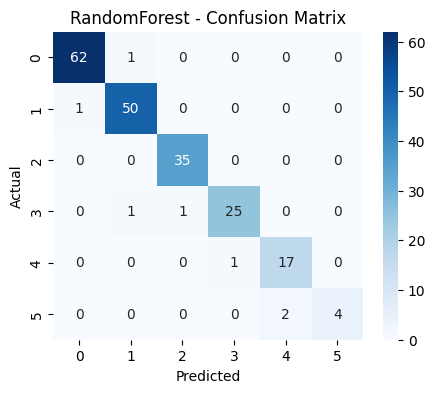

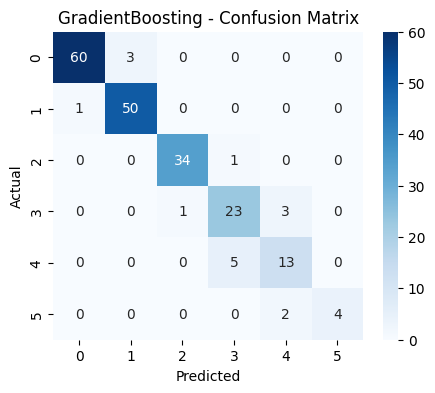

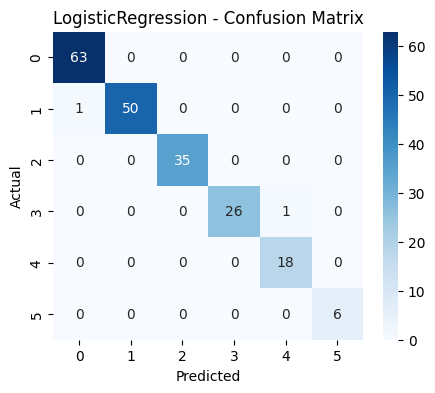

In [35]:
for name in scores:
  conf_mat = confusion_matrix(y_test, scores[name]["prediction"])

  plt.figure(figsize=(5, 4))
  sns.heatmap(conf_mat, annot=True, fmt='d', cmap="Blues")
  plt.title(f"{name} - Confusion Matrix")
  print(" ")
  plt.xlabel("Predicted")
  print(" ")
  plt.ylabel("Actual")
  plt.show()


# **Classification Reports**

In [37]:
for name in scores:
  print("="*60)
  print(f"{name} Classification Report")
  print("="*60)
  print(classification_report(y_test, scores[name]["prediction"]))


RandomForest Classification Report
              precision    recall  f1-score   support

           0       0.98      0.98      0.98        63
           1       0.96      0.98      0.97        51
           2       0.97      1.00      0.99        35
           3       0.96      0.93      0.94        27
           4       0.89      0.94      0.92        18
           5       1.00      0.67      0.80         6

    accuracy                           0.96       200
   macro avg       0.96      0.92      0.93       200
weighted avg       0.97      0.96      0.96       200

GradientBoosting Classification Report
              precision    recall  f1-score   support

           0       0.98      0.95      0.97        63
           1       0.94      0.98      0.96        51
           2       0.97      0.97      0.97        35
           3       0.79      0.85      0.82        27
           4       0.72      0.72      0.72        18
           5       1.00      0.67      0.80         6

   

# **Selection of the Best Model Automatically**

In [38]:
best_model_name = max(scores, key=lambda x: scores[x]["accuracy"])
best_model = scores[best_model_name]["model"]

print(f"Best Model: {best_model_name}")
print(f"Accuracy: {scores[best_model_name]['accuracy']:.4f}")


Best Model: LogisticRegression
Accuracy: 0.9900


# **Interpretation of the best model**

- #  Best Model Overview
  After evaluating multiple machine learning algorithms—including Random Forest, Gradient Boosting, and Logistic Regression—**the Logistic Regression model emerged as the best overall performer**, achieving the highest accuracy on the test set. Its strong performance was supported by excellent cross-validation scores, indicating that the model generalizes well and is not overfitting. Logistic Regression’s linear decision boundary appears to align well with the underlying structure of the dataset, allowing it to distinguish classes with minimal complexity while maintaining interpretability.
#



- #  Why This Model Was Selected
  Beyond accuracy, Logistic Regression offered several practical advantages that contributed to its selection as the final model for deployment. It trained quickly, required fewer computational resources than tree-based models, and produced coefficients that clearly indicate the influence of individual features—making the model easy to explain to stakeholders. Its stability, simplicity, and strong performance metrics make it the most suitable choice for production. The model was subsequently fine-tuned using hyperparameter optimization, validated through cross-validation, and saved as a serialized .pkl file.